In [1]:
import pandas as pd
import os
import numpy as np
import cv2
from tqdm import tqdm
from glob import glob
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE
from timm import create_model

In [2]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [3]:
_KVASIR_CAPSULE = 'D:\\data\\endoscopic\\kvasir_capsule'
# _KVASIR_CAPSULE_DEFORM = 'D:\\data\\endoscopic\\kvasir_capsule_deform'

# _HYPER_KVASIR = 'D:\\data\\endoscopic\\hyper_kvasir'
# _HYPER_KVASIR_LABELED_DEFORM = 'D:\\data\\endoscopic\\hyper_kvasir\\labeled_images_deform'

In [5]:
categories_path = glob(os.path.join(_KVASIR_CAPSULE,'*'))
# categories_path

In [18]:
df_meta = pd.read_csv('../resource/kvasir_capsule/metadata.csv', sep=';')
df_anno = pd.read_csv('../resource/kvasir_capsule/df_train_valid.csv')

# df_meta.head()

In [7]:
df_meta['finding_category'].value_counts()

Luminal    41511
Anatomy     5737
Name: finding_category, dtype: int64

In [15]:
df_luminal = df_meta[df_meta['finding_category'] == 'Luminal']
df_luminal['finding_class'].value_counts()

Normal clean mucosa     34338
Reduced Mucosal View     2906
Angiectasia               866
Ulcer                     854
Foreign Body              776
Lymphangiectasia          592
Erosion                   507
Blood - fresh             446
Erythema                  159
Polyp                      55
Blood - hematin            12
Name: finding_class, dtype: int64

In [12]:
list_luminal = list(pd.unique(df_luminal['finding_class']))

In [16]:
df_anotomy = df_meta[df_meta['finding_category'] == 'Anatomy']
df_anotomy['finding_class'].value_counts()

Ileocecal valve     4189
Pylorus             1538
Ampulla of Vater      10
Name: finding_class, dtype: int64

In [17]:
list_anatomy = list(pd.unique(df_anotomy['finding_class']))

In [23]:
list_cat = []
list_cls = []
for p in df_anno.path:
    class_ = p.split('/')[0]
    list_cls.append(class_)
    if class_ in list_luminal:
        list_cat.append('Luminal')
    else:
        list_cat.append('Anatomy')
df_anno['category'] = list_cat
df_anno['class'] = list_cls

In [24]:
df_anno.head()

,path,target,is_valid,category,class
0,Normal clean mucosa/5e59c7fdb16c4228_8238.jpg,9,False,Luminal,Normal clean mucosa
1,Pylorus/0531325b64674948_3516.jpg,11,False,Anatomy,Pylorus
2,Ileocecal valve/af9bd7d0e43741e3_30205.jpg,7,False,Anatomy,Ileocecal valve
3,Normal clean mucosa/eb0203196e284797_3286.jpg,9,False,Luminal,Normal clean mucosa
4,Normal clean mucosa/131368cc17e44240_4399.jpg,9,False,Luminal,Normal clean mucosa


In [37]:
dict_class = dict(df_anno['class'].value_counts())
dict_class = {k: v for k, v in sorted(dict_class.items(), key=lambda item: item[1], reverse = True)}
dict_class

{'Normal clean mucosa': 34338,
 'Ileocecal valve': 4189,
 'Reduced mucosal view': 2906,
 'Pylorus': 1529,
 'Angiectasia': 866,
 'Ulcer': 854,
 'Foreign body': 776,
 'Lymphangiectasia': 592,
 'Erosion': 506,
 'Blood - fresh': 446,
 'Erythema': 159,
 'Polyp': 55,
 'Blood - hematin': 12,
 'Ampulla of vater': 10}

In [38]:
dict_class = list(dict_class.keys())
dict_class

['Normal clean mucosa',
 'Ileocecal valve',
 'Reduced mucosal view',
 'Pylorus',
 'Angiectasia',
 'Ulcer',
 'Foreign body',
 'Lymphangiectasia',
 'Erosion',
 'Blood - fresh',
 'Erythema',
 'Polyp',
 'Blood - hematin',
 'Ampulla of vater']

In [42]:
"""
Erythema
Angiectasia
Ulcer
Erosion
Lymphangiectasia
Polyp
"""
list_pathologies = ['Erythema', 'Angiectasia', 'Ulcer', 'Erosion', 'Lymphangiectasia', 'Polyp']

In [47]:
list_target = []
list_patho = []
for c in df_anno['class']:
    list_target.append(dict_class.index(c))
    if c in list_pathologies:
        list_patho.append(True)
    else:
        list_patho.append(False)
df_anno['original_target'] = list_target
df_anno['is_patho'] = list_patho

In [48]:
df_anno.head()

,path,target,is_valid,category,class,is_patho,original_target
0,Normal clean mucosa/5e59c7fdb16c4228_8238.jpg,0,False,Luminal,Normal clean mucosa,False,0
1,Pylorus/0531325b64674948_3516.jpg,3,False,Anatomy,Pylorus,False,3
2,Ileocecal valve/af9bd7d0e43741e3_30205.jpg,1,False,Anatomy,Ileocecal valve,False,1
3,Normal clean mucosa/eb0203196e284797_3286.jpg,0,False,Luminal,Normal clean mucosa,False,0
4,Normal clean mucosa/131368cc17e44240_4399.jpg,0,False,Luminal,Normal clean mucosa,False,0


In [51]:
dict_class_patho = dict(df_anno[df_anno['is_patho'] == True]['class'].value_counts())
dict_class_patho = {k: v for k, v in sorted(dict_class_patho.items(), key=lambda item: item[1], reverse = True)}
dict_class_patho = list(dict_class_patho.keys())
dict_class_patho

['Angiectasia', 'Ulcer', 'Lymphangiectasia', 'Erosion', 'Erythema', 'Polyp']

In [74]:
df_anno[df_anno['is_patho']==True]['class']

16       Lymphangiectasia
25            Angiectasia
29            Angiectasia
49                Erosion
60            Angiectasia
               ...       
47131         Angiectasia
47145             Erosion
47160         Angiectasia
47180         Angiectasia
47188         Angiectasia
Name: class, Length: 3032, dtype: object

In [78]:
list_target_patho = []
df_patho = df_anno[df_anno['is_patho']==True]
for c in df_patho['class']:
    # if c in list_pathologies:
    list_target_patho.append(dict_class_patho.index(c))    
    # else:
    #     list_target_patho.append(0)
df_patho['patho_target'] = list_target_patho

C:\Users\Admin\anaconda3\envs\cls\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [79]:
df_patho

,path,target,is_valid,category,class,is_patho,original_target,patho_target
16,Lymphangiectasia/64440803f87b4843_21811.jpg,7,False,Luminal,Lymphangiectasia,True,7,2
25,Angiectasia/64440803f87b4843_18847.jpg,4,False,Luminal,Angiectasia,True,4,0
29,Angiectasia/04a78ef00c5245e0_892.jpg,4,False,Luminal,Angiectasia,True,4,0
49,Erosion/8ebf0e483cac48d6_13434.jpg,8,False,Luminal,Erosion,True,8,3
60,Angiectasia/64440803f87b4843_18712.jpg,4,False,Luminal,Angiectasia,True,4,0
...,...,...,...,...,...,...,...,...
47131,Angiectasia/64440803f87b4843_18574.jpg,4,True,Luminal,Angiectasia,True,4,0
47145,Erosion/fb86bc87d3874cd7_453.jpg,8,True,Luminal,Erosion,True,8,3
47160,Angiectasia/64440803f87b4843_18832.jpg,4,True,Luminal,Angiectasia,True,4,0
47180,Angiectasia/b2134f4a6f864613_21069.jpg,4,True,Luminal,Angiectasia,True,4,0


In [86]:
x = df_patho['path']
y = df_patho['patho_target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train_lab, x_train_unlab, y_train_lab, y_train_unlab = train_test_split(x_train, 
                                                                          y_train, 
                                                                          test_size=0.32, 
                                                                          random_state=0)


df_train_lab = pd.DataFrame([])
df_train_lab = pd.DataFrame([])
df_train_lab['image'] = x_train_lab
df_train_lab['target'] = y_train_lab
df_train_lab['is_valid'] = False
df_train_lab['is_labeled'] = True

df_train_unlab = pd.DataFrame([])
df_train_unlab = pd.DataFrame([])
df_train_unlab['image'] = x_train_unlab
df_train_unlab['target'] = y_train_unlab
df_train_unlab['is_valid'] = False
df_train_unlab['is_labeled'] = False


df_valid['image'] = x_test
df_valid['target'] = y_test
df_valid['is_valid'] = True
df_valid['is_labeled'] = True

In [91]:
df_full = pd.concat([df_train_lab, df_train_unlab, df_valid], axis=0).reset_index()
del df_full['index']
df_full

,image,target,is_valid,is_labeled
0,Angiectasia/d369e4f163df4aba_26375.jpg,0,False,True
1,Lymphangiectasia/64440803f87b4843_17845.jpg,2,False,True
2,Lymphangiectasia/7ad22d50ebaf4596_27614.jpg,2,False,True
3,Erosion/d626f4f4a5ac4785_50090.jpg,3,False,True
4,Ulcer/d626f4f4a5ac4785_48501.jpg,1,False,True
...,...,...,...,...
3027,Ulcer/7a47e8eacea04e64_51630.jpg,1,True,True
3028,Angiectasia/64440803f87b4843_18875.jpg,0,True,True
3029,Ulcer/d626f4f4a5ac4785_48431.jpg,1,True,True
3030,Angiectasia/64440803f87b4843_18613.jpg,0,True,True


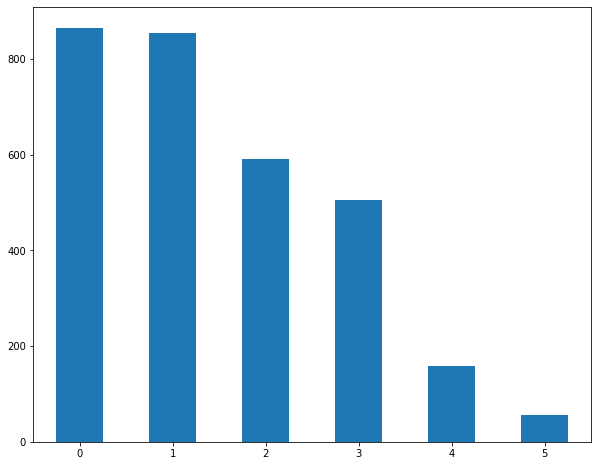

In [92]:
fig = df_full['target'].value_counts().plot(kind='bar', figsize=(10, 8), fontsize=10, rot=0).get_figure()

In [93]:
df_full.to_csv('../resource/kvasir_capsule/df_pathologies.csv', index=False, header=True)

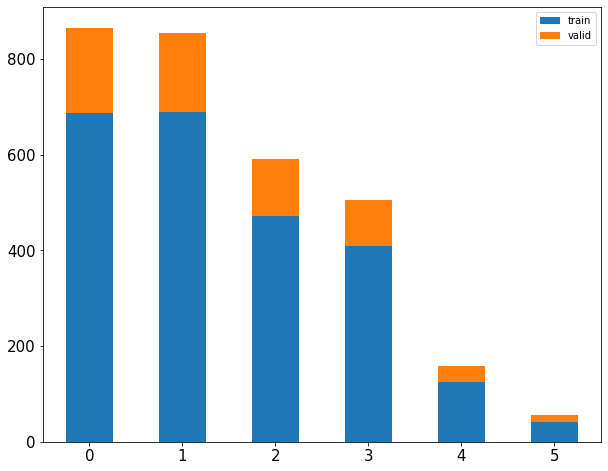

In [84]:
cnt_train = df_train['target'].value_counts()
cnt_valid = df_valid['target'].value_counts()

df_cnt = pd.DataFrame({'train': cnt_train,'valid': cnt_valid})
chart = df_cnt.plot.bar(rot=0, figsize=(10, 8), fontsize=15, stacked=True).get_figure()
# chart.savefig('../resource/visualize/visual_sup.png')

In [69]:
# cnt_train = df_train['Groupby_Categories']
# cnt_train_labeled, cnt_train_unlabeled = train_test_split(cnt_train, test_size = 0.9, random_state = 0)
# cnt_train_labeled, cnt_train_unlabeled = cnt_train_labeled.value_counts(), cnt_train_unlabeled.value_counts()
# cnt_valid = df_valid['Groupby_Categories'].value_counts()

# df_cnt = pd.DataFrame({'train_labeled': cnt_train_labeled, 
                       
#                        'train_unlabeled': cnt_train_unlabeled,
#                        'valid': cnt_valid,
#                        })
# chart_semi = df_cnt.plot.bar(rot=0, 
#                         figsize=(10, 8), 
#                         fontsize=15,
#                         color={"train_labeled": "#1f76b5", "train_unlabeled": "green", "valid":"#fe7e0e"},
#                         stacked=True).get_figure()
# chart_semi.savefig('../resource/visualize/visual_semi_1_9.png')

In [70]:
# cnt_train_labeled, cnt_train_unlabeled

In [71]:
# df_train['Groupby_Categories'].value_counts()
# fig_train.savefig('../resource/visualize/groupcat_train.png')

In [72]:
# df_valid['Groupby_Categories'].value_counts()
# fig_valid.savefig('../resource/visualize/groupcat_valid.png')

In [14]:
# fig.savefig('../resource/visualize/groupcat.png')

In [15]:
# df_full.to_csv('../resource/hyper_kvasir/full_labeled_group.csv', index=False, header=True)